In [ ]:
# default_exp core

# fastproaudio core

> API details.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export

#from fastai.vision.all import *
from fastai.data.all import *
from subprocess import Popen, PIPE
import pyzenodo3
import torchaudio
#from zipfile import ZipFile

# some data urls
URLs.AUDIOMDPI = 'https://zenodo.org/record/3562442'
URLs.MARCO = URLs.AUDIOMDPI  # just a shorthand alias I'm more likely to remember
URLs.SIGNALTRAIN_LA2A_1_1 = 'https://zenodo.org/record/3824876'
URLs.SIGNALTRAIN_LA2A_REDUCED = 'http://hedges.belmont.edu/data/SignalTrain_LA2A_Reduced.tgz'

Some audio data urls: 

URLs.AUDIOMDPI = 'https://zenodo.org/record/3562442'

URLs.MARCO = URLs.AUDIOMDPI  # just a shorthand alias I'm more likely to remember

URLs.SIGNALTRAIN_LA2A_1_1 = 'https://zenodo.org/record/3824876'

URLs.SIGNALTRAIN_LA2A_REDUCED = 'http://hedges.belmont.edu/data/SignalTrain_LA2A_Reduced.tgz'

In [ ]:
#export
def zenodo_url_to_data_url(url):
    #%pip install pyzenodo3 -q
    zen = pyzenodo3.Zenodo()
    record = url.split('/')[-1]
    return zen.get_record(record).data['files'][0]['links']['self']  

In [ ]:
#slow
print(URLs.MARCO)
print(zenodo_url_to_data_url(URLs.MARCO))

https://zenodo.org/record/3562442
https://zenodo.org/api/files/d6589bb4-d6a6-4bc6-8e51-e6334fafbe3f/AudioMDPI.zip


In [ ]:
#slow
print(URLs.SIGNALTRAIN_LA2A_1_1)
print(zenodo_url_to_data_url(URLs.SIGNALTRAIN_LA2A_1_1))

https://zenodo.org/record/3824876
https://zenodo.org/api/files/df302f12-7355-452e-93d1-b0c9344608f7/SignalTrain_LA2A_Dataset_1.1.tgz


In [ ]:
#export 

# extract_func no longer supported  in untar_data, so zipfile stuff is unused
# thanks KevinB for the zip_extract! https://forums.fast.ai/t/generalizing-untar-data-to-also-work-with-zips/53741/14?u=drscotthawley
#def zip_extract(fname, dest):
#    zipfile.ZipFile(fname, mode='r').extractall(dest)

def get_audio_data(url):
    if ('zenodo' in url.lower()):
        url = zenodo_url_to_data_url(url)
    if '.zip' in url[-5:]:
        return untar_data(url)#, extract_func=zip_extract) #
    else:
        return untar_data(url) 

Try downloading a sample .tgz file

In [ ]:
#slow
path_st = get_audio_data(URLs.SIGNALTRAIN_LA2A_REDUCED)
path_st

Path('/home/shawley/.fastai/data/SignalTrain_LA2A_Reduced')

And try downloading from a Zenodo URL:

In [ ]:
#slow
path_audiomdpi = get_audio_data(URLs.MARCO)
path_audiomdpi

Path('/home/shawley/.fastai/data/AudioMDPI')

In [ ]:
#all_slow

Let's use this data as an example and take a look at it:

In [ ]:
path_audiomdpi.ls()

(#4) [Path('/home/shawley/.fastai/data/AudioMDPI/LeslieWoofer'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn'),Path('/home/shawley/.fastai/data/AudioMDPI/license.txt'),Path('/home/shawley/.fastai/data/AudioMDPI/6176ChannelStrip')]

We'll grab the `LeslieHorn` subset

In [ ]:
horn = path_audiomdpi / "LeslieHorn"; horn.ls()

(#4) [Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/readme.txt'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/chorale'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/tremolo'),Path('/home/shawley/.fastai/data/AudioMDPI/LeslieHorn/dry')]

In [ ]:
path_dry = horn /'dry'
#path_trem = horn / 'tremolo'
audio_extensions = ['.m3u', '.ram', '.au', '.snd', '.mp3','.wav']
fnames_dry = get_files(path_dry, extensions=audio_extensions)
#fnames_trem = get_files(path_trem, extensions=audio_extensions)

In [ ]:
waveform, sample_rate = torchaudio.load(fnames_dry[0])

The [PyTorch torchaudio tutorial on waveform processing](https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html) introduces some helpful utility routines, though I don't see these as being importable, so we'll have to define them again here: 

In [ ]:
# export
# utility routines from the torchaudio "audio preprocessing" tutorial:
# https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
def print_stats(waveform, sample_rate=None, src=None):
  if src:
    print("-" * 10)
    print("Source:", src)
    print("-" * 10)
  if sample_rate:
    print("Sample Rate:", sample_rate)
  print("Shape:", tuple(waveform.shape))
  print("Dtype:", waveform.dtype)
  print(f" - Max:     {waveform.max().item():6.3f}")
  print(f" - Min:     {waveform.min().item():6.3f}")
  print(f" - Mean:    {waveform.mean().item():6.3f}")
  print(f" - Std Dev: {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth=1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].specgram(waveform[c], Fs=sample_rate)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channel {c+1}')
    if xlim:
      axes[c].set_xlim(xlim)
  figure.suptitle(title)
  plt.show(block=False)

def play_audio(waveform, sample_rate):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  if num_channels == 1:
    display(Audio(waveform[0], rate=sample_rate))
  elif num_channels == 2:
    display(Audio((waveform[0], waveform[1]), rate=sample_rate))
  else:
    raise ValueError("Waveform with more than 2 channels are not supported.")

def inspect_file(path):
  print("-" * 10)
  print("Source:", path)
  print("-" * 10)
  print(f" - File size: {os.path.getsize(path)} bytes")
  print(f" - {torchaudio.info(path)}")

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

def plot_mel_fbank(fbank, title=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Filter bank')
  axs.imshow(fbank, aspect='auto')
  axs.set_ylabel('frequency bin')
  axs.set_xlabel('mel bin')
  plt.show(block=False)

def get_spectrogram(
    n_fft = 400,
    win_len = None,
    hop_len = None,
    power = 2.0,
):
  waveform, _ = get_speech_sample()
  spectrogram = T.Spectrogram(
      n_fft=n_fft,
      win_length=win_len,
      hop_length=hop_len,
      center=True,
      pad_mode="reflect",
      power=power,
  )
  return spectrogram(waveform)

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)

def plot_kaldi_pitch(waveform, sample_rate, pitch, nfcc):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Kaldi Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln1 = axis.plot(time_axis, pitch[0], linewidth=2, label='Pitch', color='green')
  axis.set_ylim((-1.3, 1.3))

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, nfcc.shape[1])
  ln2 = axis2.plot(
      time_axis, nfcc[0], linewidth=2, label='NFCC', color='blue', linestyle='--')

  lns = ln1 + ln2
  labels = [l.get_label() for l in lns]
  axis.legend(lns, labels, loc=0)
  plt.show(block=False)

In [ ]:
# slow
def show_audio(waveform, sample_rate):
    print_stats(waveform, sample_rate=sample_rate)
    plot_waveform(waveform, sample_rate)
    plot_specgram(waveform, sample_rate)
    play_audio(waveform, sample_rate)

Sample Rate: 44100
Shape: (1, 110250)
Dtype: torch.float32
 - Max:      1.000
 - Min:     -0.973
 - Mean:    -0.000
 - Std Dev:  0.086

tensor([[0., 0., 0.,  ..., 0., 0., 0.]])



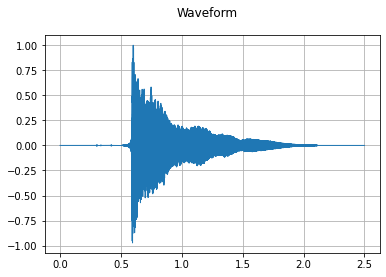

/home/shawley/envs/fastai/lib/python3.9/site-packages/matplotlib/axes/_axes.py:7723: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


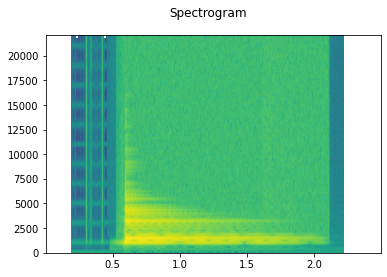

In [ ]:
from IPython.display import Audio 

show_audio(waveform, sample_rate)